In [2]:
import numpy as np
import pandas as pd
import joblib   
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    classification_report
)

In [3]:
df = pd.read_csv("multi_crop_disease_dataset_20000_rows.csv")
df.head()

,Crop,Disease,Temperature(C),Humidity(%),Rainfall(mm),Soil_pH,Soil_Moisture(%),Leaf_Spots,Wilting
0,Apple,Apple Scab,27.5,47,239,7.5,17,1,1
1,Groundnut,Tikka Disease,38.4,48,275,8.1,66,1,1
2,Maize,Downy Mildew,40.7,47,164,6.6,41,1,0
3,Mango,Anthracnose,16.0,80,295,7.1,87,1,1
4,Potato,Early Blight,24.7,56,146,7.0,45,1,1


In [5]:
df.shape

(20000, 9)

<Axes: ylabel='count'>

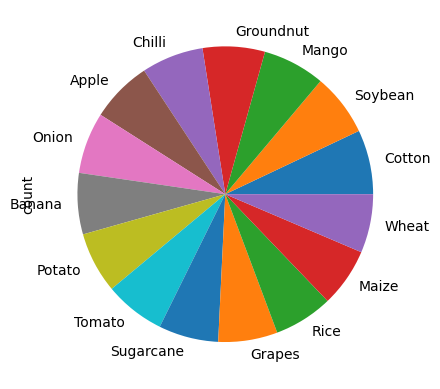

In [12]:
df['Crop'].value_counts().plot(kind='pie')

In [6]:
df.isnull().sum()

Crop                0
Disease             0
Temperature(C)      0
Humidity(%)         0
Rainfall(mm)        0
Soil_pH             0
Soil_Moisture(%)    0
Leaf_Spots          0
Wilting             0
dtype: int64

In [7]:
df.columns

Index(['Crop', 'Disease', 'Temperature(C)', 'Humidity(%)', 'Rainfall(mm)',
       'Soil_pH', 'Soil_Moisture(%)', 'Leaf_Spots', 'Wilting'],
      dtype='object')

In [9]:
df.value_counts()

Crop   Disease     Temperature(C)  Humidity(%)  Rainfall(mm)  Soil_pH  Soil_Moisture(%)  Leaf_Spots  Wilting
Wheat  Smut        41.5            95           356           4.8      61                1           1          1
                   41.6            86           69            6.9      22                1           1          1
                   41.7            38           258           4.9      75                1           0          1
                                   52           109           4.9      36                1           1          1
                                   88           230           7.5      42                1           0          1
                                                                                                               ..
Apple  Apple Scab  15.5            66           178           5.9      50                1           1          1
                   15.6            38           93            5.4      41                0   

In [23]:
# 2. DISEASE → CATEGORY
# =========================================================
fungal = ["Blight", "Mildew", "Rust", "Leaf"]
bacterial = ["Bacterial", "Soft"]
viral = ["Mosaic", "Curl", "Yellow"]
pest = ["Borer", "Aphid", "Whitefly"]

def map_category(disease):
    if any(w in disease for w in fungal):
        return "Fungal"
    elif any(w in disease for w in bacterial):
        return "Bacterial"
    elif any(w in disease for w in viral):
        return "Viral"
    elif any(w in disease for w in pest):
        return "Pest"
    else:
        return "Healthy"

df["Category"] = df["Disease"].apply(map_category)

In [24]:
# 3. BALANCED REDUCTION
# =========================================================
df_small = (
    df.groupby("Category", group_keys=False)
      .apply(lambda x: x.sample(min(len(x), 800), random_state=42))
)

C:\Users\Karan\AppData\Local\Temp\ipykernel_6108\1602206001.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(min(len(x), 800), random_state=42))


In [25]:
# 4. FEATURES / TARGET
# =========================================================
X = df_small.drop(columns=["Disease", "Category"])
y = df_small["Category"]

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

cat_features = [X.columns.get_loc("Crop")]

In [26]:
# 5. TRAIN TEST SPLIT
# =========================================================
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


In [27]:
# 6. CATBOOST MODEL
# =========================================================
model = CatBoostClassifier(
    iterations=500,
    depth=8,
    learning_rate=0.08,
    loss_function="MultiClass",
    eval_metric="TotalF1",
    random_seed=42,
    verbose=100
)

print("\nTraining CatBoost model...")
model.fit(
    X_train,
    y_train,
    cat_features=cat_features,
    eval_set=(X_test, y_test),
    use_best_model=True
)



Training CatBoost model...
0:	learn: 0.7536695	test: 0.7613721	best: 0.7613721 (0)	total: 52.3ms	remaining: 26.1s
100:	learn: 0.8929399	test: 0.7683065	best: 0.7875000 (3)	total: 10.1s	remaining: 40s
200:	learn: 0.9593714	test: 0.7524263	best: 0.7875000 (3)	total: 20.8s	remaining: 30.9s
300:	learn: 0.9828125	test: 0.7644079	best: 0.7875000 (3)	total: 31.1s	remaining: 20.6s
400:	learn: 0.9968750	test: 0.7646113	best: 0.7875000 (3)	total: 41.2s	remaining: 10.2s
499:	learn: 1.0000000	test: 0.7615686	best: 0.7875000 (3)	total: 51s	remaining: 0us

bestTest = 0.7875
bestIteration = 3

Shrink model to first 4 iterations.


In [28]:
# 7. EVALUATION
# =========================================================
y_pred = model.predict(X_test)
y_pred = y_pred.astype(int)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average="weighted")
precision = precision_score(y_test, y_pred, average="weighted")
recall = recall_score(y_test, y_pred, average="weighted")

print("\n================== RESULTS ==================")
print(f"Accuracy  : {accuracy:.4f}")
print(f"F1 Score  : {f1:.4f}")
print(f"Precision : {precision:.4f}")
print(f"Recall    : {recall:.4f}")

print("\nCLASSIFICATION REPORT:\n")
print(classification_report(
    y_test,
    y_pred,
    target_names=label_encoder.classes_
))



================== RESULTS ==================
Accuracy  : 0.7875
F1 Score  : 0.7875
Precision : 0.7875
Recall    : 0.7875

CLASSIFICATION REPORT:

              precision    recall  f1-score   support

      Fungal       0.79      0.79      0.79       160
     Healthy       0.79      0.79      0.79       160

    accuracy                           0.79       320
   macro avg       0.79      0.79      0.79       320
weighted avg       0.79      0.79      0.79       320



In [29]:
# 8. SAVE MODEL + LABEL ENCODER (PKL FILES)
# =========================================================
joblib.dump(model, "catboost_crop_disease_model.pkl")
joblib.dump(label_encoder, "crop_disease_label_encoder.pkl")

print("\n✅ Model saved as: catboost_crop_disease_model.pkl")
print("✅ Label Encoder saved as: crop_disease_label_encoder.pkl")


✅ Model saved as: catboost_crop_disease_model.pkl
✅ Label Encoder saved as: crop_disease_label_encoder.pkl
